# 4. 데이터 전처리

### 라이브러리 및 데이터 불러오기

In [1]:
from geoband.API import *

In [2]:
import folium
import json
import geopandas as gpd

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import haversine

from shapely.geometry import Point, Polygon, MultiPolygon
from PIL import Image

import platform

from IPython.display import set_matplotlib_formats

if platform.system() == 'Darwin':
    plt.rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    plt.rc('font', family = 'Malgun Gothic')

plt.rc('axes', unicode_minus=False)

set_matplotlib_formats('retina')

import warnings
warnings.filterwarnings(action='ignore')

import pathlib
from tqdm import tqdm, notebook
import os

%matplotlib inline

/opt/app-root/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# 데이터 불러오기
input_path = pathlib.Path('./data')
if not input_path.is_dir():
    input_path.mkdir()

GetCompasData('SBJ_2009_001', '1', input_path.joinpath('01.광양시_충전소설치현황.csv'))

# COMPAS 데이터
충전소설치현황 = pd.read_csv('./data/01.광양시_충전소설치현황.csv')

# feature_gdf
feature_gdf = gpd.read_file('./data/feature_gdf.geojson')

# 1. Feature scaling

##  MinMaxScaler
- feature별로 상위 30퍼센트 격자만 추출
- 즉, feature별로 상위 30퍼센트 격자들의 교집합만 고려
- 충분히 40개 이상은 뽑을 수 있음

In [4]:
def MinMaxScaler(values):
    min_value = values.min()
    max_value = values.max()
    return (values-min_value)/(max_value - min_value)

In [5]:
features = ['생산가능인구수', '자동차보유*전기차비율', '토지이용압축도', 
            '교통량', '주차장접근성', '주차장흡인력']
의사결정요소 = ['밀집도', '접근성']

In [6]:
# feature 별로 상위 30퍼센트 뽑아서 minmaxscale

scale_df = feature_gdf[['gid', 'geometry']]
for feature in features:
    print(f'0이 아닌 {feature} 의 갯수 :',feature_gdf[feature_gdf[feature] != 0][feature].count())
    temp = feature_gdf[feature_gdf[feature] != 0][feature].quantile(0.7)
    print(f'{feature}의 상위 30퍼 갯수 :',feature_gdf[feature_gdf[feature] >= temp][feature].count(), '\n')
    scale_df = pd.merge(scale_df, MinMaxScaler(feature_gdf[feature_gdf[feature] >= temp][feature]).to_frame(), left_index = True, right_index = True, how = 'left')

scale_df = scale_df.fillna(0)

0이 아닌 생산가능인구수 의 갯수 : 820
생산가능인구수의 상위 30퍼 갯수 : 250 

0이 아닌 자동차보유*전기차비율 의 갯수 : 1587
자동차보유*전기차비율의 상위 30퍼 갯수 : 478 

0이 아닌 토지이용압축도 의 갯수 : 2218
토지이용압축도의 상위 30퍼 갯수 : 667 

0이 아닌 교통량 의 갯수 : 1955
교통량의 상위 30퍼 갯수 : 587 

0이 아닌 주차장접근성 의 갯수 : 7790
주차장접근성의 상위 30퍼 갯수 : 2352 

0이 아닌 주차장흡인력 의 갯수 : 7804
주차장흡인력의 상위 30퍼 갯수 : 2341 



In [7]:
# 의사결정요소를 각 feature를 합해서 구함
for i in range(2):
    scale_df[의사결정요소[i]] = scale_df[features[3*i]] + scale_df[features[3*i+1]] + scale_df[features[3*i+2]]

scale_df

,gid,geometry,생산가능인구수,자동차보유*전기차비율,토지이용압축도,교통량,주차장접근성,주차장흡인력,밀집도,접근성
0,라라02ab74ab,"POLYGON ((127.52468 35.06332, 127.52468 35.065...",0.0,0.0,0.0,0.0,0.082300,0.0,0.0,0.082300
1,라라02ab74ba,"POLYGON ((127.52468 35.06557, 127.52468 35.067...",0.0,0.0,0.0,0.0,0.082300,0.0,0.0,0.082300
2,라라02ab74bb,"POLYGON ((127.52468 35.06783, 127.52468 35.070...",0.0,0.0,0.0,0.0,0.103360,0.0,0.0,0.103360
3,라라02ab75aa,"POLYGON ((127.52468 35.07008, 127.52468 35.072...",0.0,0.0,0.0,0.0,0.103360,0.0,0.0,0.103360
4,라라02ab75ab,"POLYGON ((127.52468 35.07233, 127.52468 35.074...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
7799,라라26aa68ba,"POLYGON ((127.78496 35.01114, 127.78497 35.013...",0.0,0.0,0.0,0.0,0.763657,0.0,0.0,0.763657
7800,라라26aa68bb,"POLYGON ((127.78497 35.01339, 127.78498 35.015...",0.0,0.0,0.0,0.0,0.649654,0.0,0.0,0.649654
7801,라라26aa69aa,"POLYGON ((127.78498 35.01564, 127.78499 35.017...",0.0,0.0,0.0,0.0,0.649654,0.0,0.0,0.649654
7802,라라26aa69ab,"POLYGON ((127.78499 35.01790, 127.78500 35.020...",0.0,0.0,0.0,0.0,0.522603,0.0,0.0,0.522603


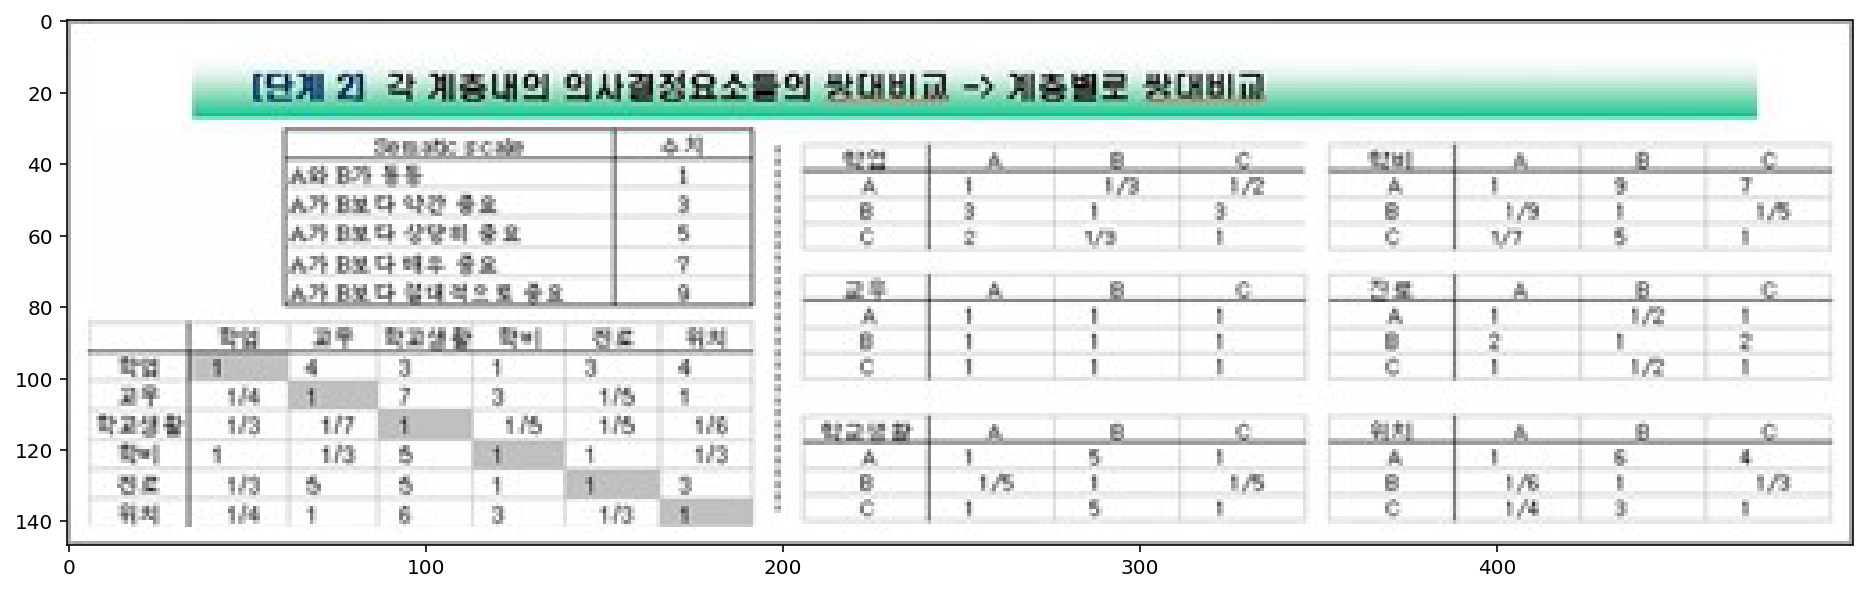

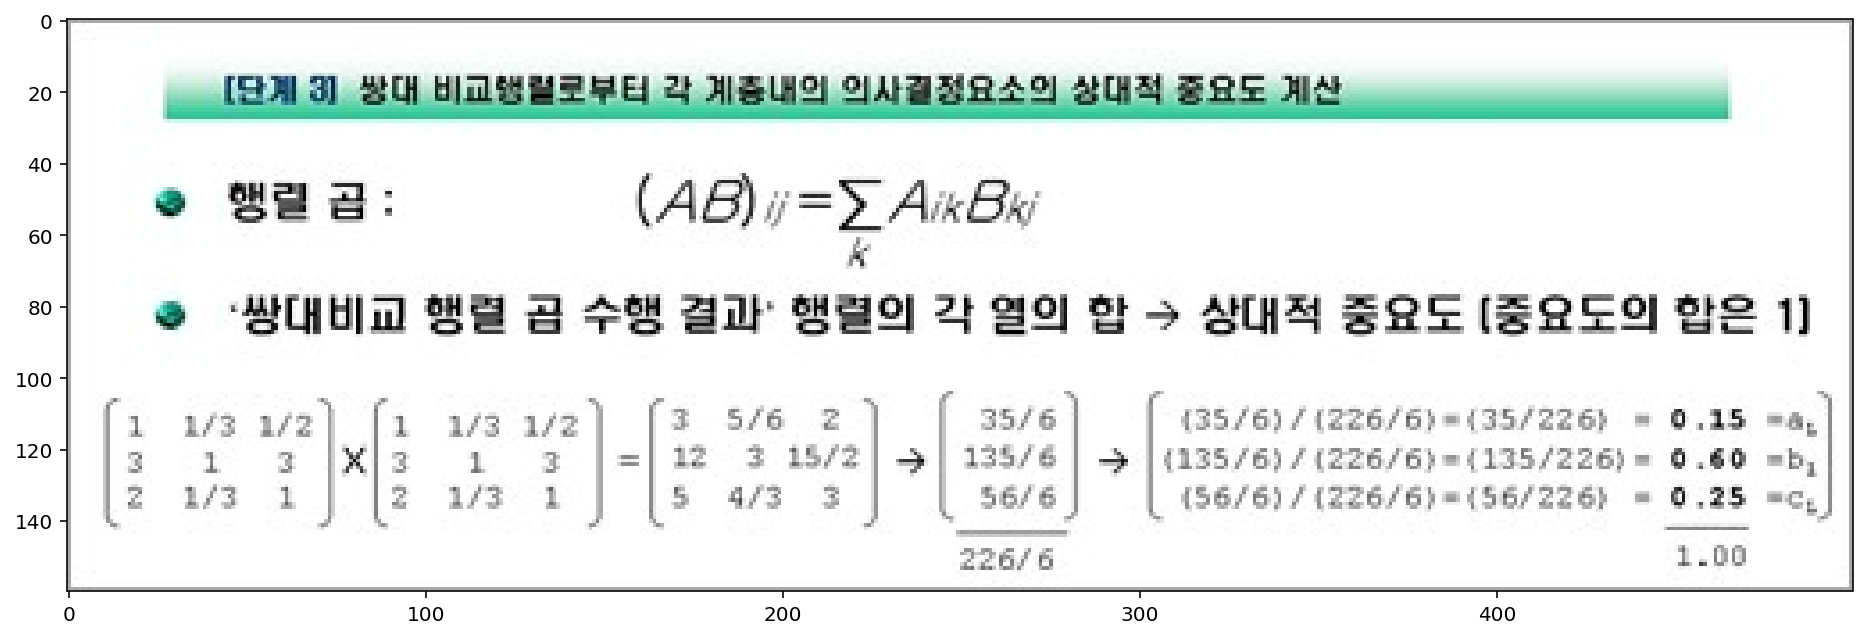

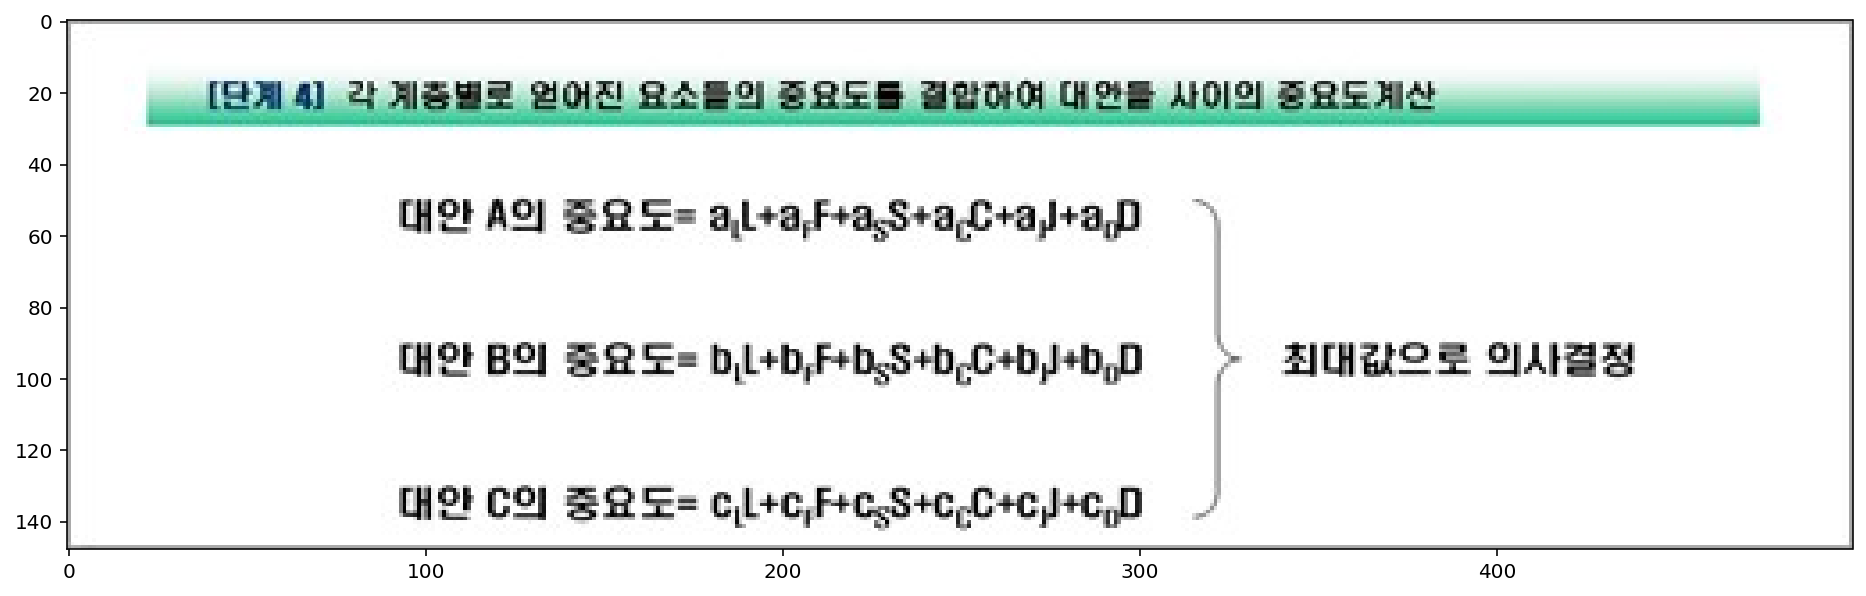

In [8]:
img1 = Image.open('./data/image1.png')
plt.figure(figsize=(16,10))
plt.imshow(img1)
img2 = Image.open('./data/image2.png')
plt.figure(figsize=(16,10))
plt.imshow(img2)
img3 = Image.open('./data/image3.png')
plt.figure(figsize=(16,10))
plt.imshow(img3)
plt.show()

# 2. 가중치 추정

- eigenvalue method사용
- 큰 의사결정요소부터 계산 후, 세부 의사결정요소 계산
- 기존 설치된 충전기의 feature 값의 평균을 비율로 계산해서 점수를 1~5로 나눔


### 점수 부여 방식
- 1 ~ 1.25 -> 1
- 1.25 ~ 1.5 -> 2
- 1.5 ~ 1.75 -> 3
- 1.75 ~ 2 -> 4
- 2이상 -> 5


### 계산 과정
- 행렬을 A라하면 A * A 내적을 해준 다음 열방향으로 더함
- 더한 값을 전체 합으로 나눠줘서 각각을 가중치로 사용

In [9]:
def Eigenvalue_Method(df):
    def cal_eigenvalue(cate, matrix):
        N = len(matrix)
        for i in range(N):
            for j in range(N):
                if matrix[i][j]:   # 이미 점수가 부여됬을 경우
                    continue
                if i==j:           # 같은 feature는 1점 부여
                    matrix[i][j] = 1
                    continue
                a, b = cate[i], cate[j]
                if a < b:
                    a, b = b, a
                    i, j = j,i
                
                # 평균비율 계산후 점수를 1~5점 부여
                if a / b < 1.25:
                    matrix[i][j] = 1
                    matrix[j][i] = 1
                elif a / b < 1.5:
                    matrix[i][j] = 2
                    matrix[j][i] = 1/2
                elif a / b < 1.75:
                    matrix[i][j] = 3
                    matrix[j][i] = 1/3
                elif a / b < 2:
                    matrix[i][j] = 4
                    matrix[j][i] = 1/4
                else:
                    matrix[i][j] = 5
                    matrix[j][i] = 1/5
            eigen_matrix = np.dot(np.array(matrix), np.array(matrix))
            eigen_vector = eigen_matrix.sum(axis = 1)
            eigen_vector = eigen_vector / eigen_vector.sum()

        return eigen_vector
    
    big_matrix = [[0 for i in range(2)] for i in range(2)]
    matrix1 = [[0 for i in range(3)] for i in range(3)]
    matrix2 = [[0 for i in range(3)] for i in range(3)]
    
    big_cate = []
    for cate in 의사결정요소:
        big_cate.append(df[cate].mean())
    
    small_cate = []
    for feature in features:
        small_cate.append(df[feature].mean())

    b_eigen_vector = cal_eigenvalue(big_cate, big_matrix)
        
    eigen_vector1 = cal_eigenvalue(small_cate[:3], matrix1)
    eigen_vector2 = cal_eigenvalue(small_cate[3:6], matrix2)
    
    total_eigenvalue = np.array([])
    total_eigenvalue = np.hstack([total_eigenvalue, b_eigen_vector[0] * eigen_vector1])
    total_eigenvalue = np.hstack([total_eigenvalue, b_eigen_vector[1] * eigen_vector2])
    
    return total_eigenvalue

In [10]:
N = len(scale_df)
M = len(충전소설치현황)

# 완,급속 충전기 있는 좌표만 뽑음
완속충전장소매핑 = {}
급속충전장소매핑 = {}

for i in tqdm(range(M)):
    급완 = 충전소설치현황.loc[i, '급속/완속']
    충전장소 = Point(충전소설치현황.loc[i,['lon','lat']].values)

    for j in range(N):
        if 충전장소.within(scale_df.loc[j, 'geometry']):
            if 급완 == '완속':
                완속충전장소매핑[i] = j
                # print(f"{i}번째 완속 충전기는 scale_df의 {j}번째 인덱스에 있음!!")
                break
            else:
                급속충전장소매핑[i] = j
                # print(f"{i}번째 완속 충전기는 scale_df의 {j}번째 인덱스에 있음!!")
                break

100%|██████████| 44/44 [00:05<00:00,  8.19it/s]


In [11]:
완속_df = scale_df.loc[완속충전장소매핑.values()]
급속_df = scale_df.loc[급속충전장소매핑.values()]

완속가중치 = Eigenvalue_Method(완속_df)
급속가중치 = Eigenvalue_Method(급속_df)

scale_df['완속_score'] = 0
scale_df['급속_score'] = 0

for i in range(6):
    scale_df['완속_score'] += scale_df[features[i]]*완속가중치[i]
    scale_df['급속_score'] += scale_df[features[i]]*급속가중치[i]

In [12]:
# 완속가중치
for i in range(6):
    print(features[i], '     ',완속가중치[i])
    if i%3==2:
        print()

생산가능인구수       0.08843537414965986
자동차보유*전기차비율       0.17687074829931973
토지이용압축도       0.06802721088435373

교통량       0.04660119391488541
주차장접근성       0.47178894665896387
주차장흡인력       0.14827652609281722



In [13]:
# 급속가중치
for i in range(6):
    print(features[i], '     ',급속가중치[i])
    if i%3==2:
        print()

생산가능인구수       0.054339010543390104
자동차보유*전기차비율       0.18004866180048662
토지이용압축도       0.09894566098945659

교통량       0.09523809523809523
주차장접근성       0.4761904761904761
주차장흡인력       0.09523809523809523



# 3. 충전기 커버 지수

## 거리를 이용해 충전기가 커버할수 있는 격자별 점수를 영향력 개념으로 선정

- 충전기격자로부터 거리가 가까우면 영향력이 높음
- 광양시에 있는 모든 충전기는 모든 격자의 영향을 미칠수 있다고 가정
- 충전기의 이용 대수는 영향력의 비례함
- 거리의 역수를 이용

In [14]:
def charger_cover(geometry, slow = False):
    lat, lon = geometry.centroid.coords[0][1], geometry.centroid.coords[0][0]
    
    total = 0
    for i in range(M):
        급완 = 충전소설치현황.loc[i, '급속/완속']
        if not slow and 급완 == '완속':
            continue
        
        이용대수 = 충전소설치현황.loc[i, '이용대수']
        y, x = 충전소설치현황.loc[i,['lon','lat']].values
        거리 = haversine.haversine((x,y),(lat,lon))
        total += (이용대수/(거리))
    return total

In [15]:
for i in range(N):
    geometry = scale_df.loc[i, 'geometry']
    scale_df.loc[i, '완속_cover'] = charger_cover(geometry, slow = True)
    scale_df.loc[i, '급속_cover'] = charger_cover(geometry, slow = False)

scale_df['완속_cover_scale'] = MinMaxScaler(scale_df['완속_cover'])+1
scale_df['급속_cover_scale'] = MinMaxScaler(scale_df['급속_cover'])+1

scale_df['완속_scale_score'] = scale_df['완속_score'] * (1/scale_df['완속_cover_scale'])
scale_df['급속_scale_score'] = scale_df['급속_score'] * (1/scale_df['급속_cover_scale'])

In [16]:
# scale_df 저장
scale_df.to_file('./data/scale_df.geojson', driver='GeoJSON')